**Baseline Setup & Data Validation**

In [ ]:
pip install pandas numpy scikit-learn nltk matplotlib


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Datasset Uploading from Kaggle**

Run this part everytime you open this colab file

In [ ]:
# --- Step 2: Automatic IMDb dataset download and baseline model ---
from google.colab import files
import os, zipfile, re, nltk, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 1️⃣ Upload kaggle.json (you downloaded this from your Kaggle account)
print("🔑 Upload your kaggle.json file here:")
files.upload()

# 2️⃣ Setup Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle --quiet

# 3️⃣ Download IMDb dataset automatically
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews -p datasets

# 4️⃣ Unzip the dataset
os.makedirs('datasets', exist_ok=True)
for file in os.listdir('datasets'):
    if file.endswith('.zip'):
        with zipfile.ZipFile(os.path.join('datasets', file), 'r') as zip_ref:
            zip_ref.extractall('datasets')

print("✅ Dataset downloaded and extracted!")

# 5️⃣ Load dataset
DATA_PATH = 'datasets/IMDB Dataset.csv'
df = pd.read_csv(DATA_PATH)
print("Rows:", len(df))
print(df.head())

# 6️⃣ Text cleaning and preprocessing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^A-Za-z\s]', ' ', text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

print("🧹 Cleaning text (takes a few minutes)...")
df['clean_review'] = df['review'].apply(clean_text)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# 7️⃣ Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_review'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# 8️⃣ TF-IDF + Logistic Regression
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)

# 9️⃣ Evaluation
print("\n📊 --- Evaluation Metrics ---")
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))
print("\nConfusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred))


🔑 Upload your kaggle.json file here:


KeyboardInterrupt: 

**Phase 2 (Hybrid BERT + BiLSTM Model).**

In [ ]:
# ===============================
# Phase 2: Hybrid BERT + BiLSTM
# ===============================

!pip install transformers torch tqdm --quiet

import torch, numpy as np, pandas as pd, re
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm.notebook import tqdm

# 1️⃣ Load preprocessed IMDb dataset from Phase 1 (clean_review, label)
df = pd.read_csv("datasets/IMDB Dataset.csv")
df['label'] = df['sentiment'].map({'positive':1, 'negative':0})

# quick clean (light)
def clean_text(text):
    text = re.sub(r'<.*?>',' ',text)
    text = re.sub(r'[^A-Za-z\s]',' ',text)
    return text.strip()
df['clean_review'] = df['review'].apply(clean_text)

# subset for faster training (optional; later use full)
df = df.sample(10000, random_state=42).reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['label'], test_size=0.2, random_state=42)

# 2️⃣ Tokenization
PRETRAINED = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        enc = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        item = {k:v.squeeze(0) for k,v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

train_ds = TextDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_ds = TextDataset(X_test.tolist(), y_test.tolist(), tokenizer)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

# 3️⃣ Model definition: BERT + BiLSTM
device = 'cuda' if torch.cuda.is_available() else 'cpu'
bert = AutoModel.from_pretrained(PRETRAINED)

class BertBiLSTM(nn.Module):
    def __init__(self, bert, hidden_dim=128, dropout=0.3):
        super().__init__()
        self.bert = bert
        self.lstm = nn.LSTM(bert.config.hidden_size, hidden_dim,
                            num_layers=1, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim*2, 1)
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        seq_output = outputs.last_hidden_state
        lstm_out,_ = self.lstm(seq_output)
        pooled = torch.mean(lstm_out, dim=1)
        out = self.dropout(pooled)
        logits = self.fc(out)
        return logits.squeeze(-1)

model = BertBiLSTM(bert).to(device)

# 4️⃣ Training loop
epochs = 2
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        optimizer.zero_grad()
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        logits = model(ids, mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Train Loss: {total_loss/len(train_loader):.4f}")

# 5️⃣ Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()
        logits = model(ids, mask).cpu()
        preds = (torch.sigmoid(logits) > 0.5).int().numpy()
        y_true.extend(labels)
        y_pred.extend(preds)

acc = metrics.accuracy_score(y_true, y_pred)
prec = metrics.precision_score(y_true, y_pred)
rec = metrics.recall_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)

print("\n📊 Hybrid BERT+BiLSTM Performance")
print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")


**BERT + BiLSTM end-to-end on the full IMDb dataset,**

In [ ]:
# ===========================
# Full fine-tune: BERT + BiLSTM
# Colab-ready (GPU). Run in a single cell.
# ===========================

# Install required libs
!pip install -q transformers datasets accelerate

import os, re, random, time
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm.notebook import tqdm

# ---------- Config ----------
SEED = 42
PRETRAINED = "bert-base-uncased"
DATA_PATHS = [
    "/content/IMDB Dataset.csv",
    "/content/datasets/IMDB Dataset.csv",
    "datasets/IMDB Dataset.csv"
]
OUTPUT_DIR = "/content/bert_bilstm_checkpoints"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Training hyperparams (change if needed)
MAX_LEN = 192           # max tokens
BATCH_SIZE = 16         # try 16 or 32 depending on GPU memory
NUM_EPOCHS = 3          # 3-4 is typical for fine-tuning
LR = 2e-5
WEIGHT_DECAY = 0.01
GRAD_CLIP = 1.0
USE_AMP = True          # automatic mixed precision (speeds up & saves memory)

# reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---------- Load dataset (try multiple paths) ----------
DATA_PATH = None
for p in DATA_PATHS:
    if os.path.exists(p):
        DATA_PATH = p
        break
if DATA_PATH is None:
    raise FileNotFoundError("IMDB Dataset.csv not found. Place it at /content/ or /content/datasets/ or datasets/")

print("Loading:", DATA_PATH)
df = pd.read_csv(DATA_PATH)
# minimal cleaning (we'll rely on tokenizer)
def clean_text_min(text):
    text = re.sub(r'<.*?>', ' ', str(text))
    text = re.sub(r'[\r\n]+', ' ', text)
    return text.strip()
df['clean_review'] = df['review'].apply(clean_text_min)
df['label'] = df['sentiment'].map({'positive':1, 'negative':0})

# Balanced dataset expected; quick check
print("Total rows:", len(df))
print(df['label'].value_counts())

# ---------- Train / Val split ----------
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['clean_review'].tolist(), df['label'].tolist(), test_size=0.2, stratify=df['label'], random_state=SEED
)
print("Train:", len(train_texts), "Val:", len(val_texts))

# ---------- Tokenizer ----------
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)

# ---------- Dataset & Dataloader ----------
class ImdbDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        enc = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

train_ds = ImdbDataset(train_texts, train_labels, tokenizer, max_len=MAX_LEN)
val_ds = ImdbDataset(val_texts, val_labels, tokenizer, max_len=MAX_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)

# ---------- Model: BERT + BiLSTM (end-to-end finetune) ----------
class BertBiLSTM(nn.Module):
    def __init__(self, pretrained_name, lstm_hidden=256, lstm_layers=1, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_name)
        hidden_size = self.bert.config.hidden_size
        self.lstm = nn.LSTM(hidden_size, lstm_hidden, num_layers=lstm_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(lstm_hidden * 2, 1)
    def forward(self, input_ids, attention_mask):
        # Full fine-tuning: allow gradients through BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        seq_out = outputs.last_hidden_state          # (batch, seq_len, hidden)
        lstm_out, _ = self.lstm(seq_out)            # (batch, seq_len, hidden*2)
        pooled = torch.mean(lstm_out * attention_mask.unsqueeze(-1), dim=1)  # mask-aware mean pooling
        x = self.dropout(pooled)
        logits = self.classifier(x)                 # (batch, 1)
        return logits.squeeze(-1)

model = BertBiLSTM(PRETRAINED, lstm_hidden=256, lstm_layers=1, dropout=0.3).to(device)
print("Model params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# ---------- Optimizer + Scheduler ----------
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": WEIGHT_DECAY,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=LR)
total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(0.05 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# ---------- Training / Eval helpers ----------
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP and device=='cuda')

def train_epoch(model, loader, optimizer, scheduler, device, epoch):
    model.train()
    total_loss = 0.0
    pbar = tqdm(loader, desc=f"Train E{epoch}")
    for batch in pbar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        with torch.cuda.amp.autocast(enabled=(USE_AMP and device=='cuda')):
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels)
        scaler.scale(loss).backward()
        # gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        scaler.step(optimizer)
        scaler.update()
        if scheduler is not None:
            scheduler.step()
        total_loss += loss.item()
        pbar.set_postfix({"loss": f"{total_loss/(pbar.n+1):.4f}"})
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Eval"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()
            logits = model(input_ids=input_ids, attention_mask=attention_mask).cpu()
            probs = torch.sigmoid(logits).numpy()
            preds = (probs > 0.5).astype(int)
            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())
    acc = metrics.accuracy_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    rec = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    cm = metrics.confusion_matrix(y_true, y_pred)
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "cm":cm}

# ---------- Checkpoint saver ----------
def save_checkpoint(model, optimizer, scheduler, epoch, path):
    ckpt = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict() if scheduler is not None else None,
        "epoch": epoch
    }
    torch.save(ckpt, path)

# ---------- Main training loop ----------
best_val_f1 = 0.0
best_ckpt = None
start_time = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device, epoch)
    val_metrics = evaluate(model, val_loader, device)
    print(f"\nEpoch {epoch} summary | Train Loss: {train_loss:.4f} | Val Acc: {val_metrics['acc']:.4f} | Val F1: {val_metrics['f1']:.4f}")
    # save checkpoint each epoch
    ckpt_path = os.path.join(OUTPUT_DIR, f"bert_bilstm_epoch{epoch}.pt")
    save_checkpoint(model, optimizer, scheduler, epoch, ckpt_path)
    # save best
    if val_metrics['f1'] > best_val_f1:
        best_val_f1 = val_metrics['f1']
        best_ckpt = ckpt_path
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_model_state.pt"))
    # quick clear cuda cache
    if device == 'cuda':
        torch.cuda.empty_cache()

total_time = time.time() - start_time
print(f"\nTraining finished in {total_time/60:.2f} minutes. Best Val F1: {best_val_f1:.4f}")
print("Best checkpoint:", best_ckpt)

# ---------- Final evaluation on validation set ----------
final_metrics = evaluate(model, val_loader, device)
print("\nFinal Validation Metrics (end of run):")
print(f"Accuracy: {final_metrics['acc']:.4f} | Precision: {final_metrics['prec']:.4f} | Recall: {final_metrics['rec']:.4f} | F1: {final_metrics['f1']:.4f}")
print("Confusion Matrix:\n", final_metrics['cm'])

# Save tokenizer + config
tokenizer.save_pretrained(OUTPUT_DIR)
print("Tokenizer and best model saved to", OUTPUT_DIR)


**Phase 3: Domain Adaptation / Transfer Learning**

In [ ]:
!pip install -q datasets

from datasets import load_dataset

print("⏬ Downloading Yelp Polarity dataset from Hugging Face...")
dataset = load_dataset("yelp_polarity")

# Convert to Pandas DataFrame
train_df = dataset["train"].to_pandas()
test_df = dataset["test"].to_pandas()

# The dataset uses 'label' 0=negative, 1=positive
train_df.columns = ['label', 'review']
test_df.columns = ['label', 'review']

print("✅ Dataset loaded successfully!")
print(train_df.head())


In [ ]:
# ===============================
# Phase 3: Zero-Shot Domain Transfer (IMDb → Yelp)
# ===============================

!pip install -q transformers torch tqdm scikit-learn datasets

# ---- Imports ----
import pandas as pd, torch, re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn import metrics
from tqdm.notebook import tqdm
from datasets import load_dataset

# ---- Device & Paths ----
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PRETRAINED = "bert-base-uncased"
MODEL_PATH = "/content/bert_bilstm_checkpoints/best_model_state.pt"
TOKENIZER_PATH = "/content/bert_bilstm_checkpoints"

print("Device:", DEVICE)

# ---- Load Yelp dataset from Hugging Face ----
print("⏬ Downloading Yelp Polarity dataset from Hugging Face...")
dataset = load_dataset("yelp_polarity")

# Convert to Pandas
train_df = dataset["train"].to_pandas()
test_df = dataset["test"].to_pandas()

train_df = dataset["train"].to_pandas()[['label', 'text']].rename(columns={'text': 'review'})
test_df = dataset["test"].to_pandas()[['label', 'text']].rename(columns={'text': 'review'})


print("✅ Dataset loaded successfully!")
print(train_df.head())

# ---- Tokenizer ----
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

# ---- Model Definition (matches IMDb fine-tuned version) ----
class BertBiLSTM(torch.nn.Module):
    def __init__(self, pretrained_name, lstm_hidden=256, lstm_layers=1, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_name)
        hidden_size = self.bert.config.hidden_size
        self.lstm = torch.nn.LSTM(hidden_size, lstm_hidden, num_layers=lstm_layers,
                                  batch_first=True, bidirectional=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(lstm_hidden * 2, 1)  # ✅ correct naming
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        seq_out = outputs.last_hidden_state
        lstm_out,_ = self.lstm(seq_out)
        pooled = torch.mean(lstm_out * attention_mask.unsqueeze(-1), dim=1)
        x = self.dropout(pooled)
        logits = self.classifier(x)
        return logits.squeeze(-1)

# ---- Load IMDb fine-tuned model ----
model = BertBiLSTM(PRETRAINED)
state = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.to(DEVICE)
model.eval()
print("✅ IMDb-trained model loaded successfully.")

# ---- Sample smaller Yelp test set for quick evaluation ----
test_df = test_df.sample(5000, random_state=42).reset_index(drop=True)


# ---- Dataset + Dataloader ----
class SimpleDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts; self.labels = labels; self.tokenizer = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(str(self.texts[idx]),
                             truncation=True, padding='max_length',
                             max_length=self.max_len, return_tensors='pt')
        item = {k:v.squeeze(0) for k,v in enc.items()}
        # Ensure labels are integers before creating tensor
        item['labels'] = torch.tensor(int(self.labels[idx]), dtype=torch.float)
        return item

test_ds = SimpleDataset(test_df['review'].tolist(), test_df['label'].tolist(), tokenizer)
test_loader = DataLoader(test_ds, batch_size=32)

# ---- Evaluation ----
y_true, y_pred = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating on Yelp"):
        ids = batch['input_ids'].to(DEVICE)
        mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].cpu().numpy()
        logits = model(ids, mask).cpu()
        preds = (torch.sigmoid(logits) > 0.5).int().numpy()
        y_true.extend(labels)
        y_pred.extend(preds)

acc = metrics.accuracy_score(y_true, y_pred)
prec = metrics.precision_score(y_true, y_pred)
rec = metrics.recall_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)

print("\n📊 Zero-Shot Transfer (IMDb → Yelp)")
print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

**Domain Adaptation (Yelp Fine-Tuning)**

In [ ]:
# ===============================
# Phase 3.2: Domain Adaptation — Fine-tune IMDb model on Yelp (10%)
# ===============================

import torch, pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from tqdm.notebook import tqdm
from sklearn import metrics
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PRETRAINED = "bert-base-uncased"
MODEL_PATH = "/content/bert_bilstm_checkpoints/best_model_state.pt"
TOKENIZER_PATH = "/content/bert_bilstm_checkpoints"

print("Device:", DEVICE)

# ---- Load Yelp dataset ----
dataset = load_dataset("yelp_polarity")
train_df = dataset["train"].to_pandas()[['label','text']].rename(columns={'text':'review'})
test_df = dataset["test"].to_pandas()[['label','text']].rename(columns={'text':'review'})

# ---- Use only 10% of Yelp train set for fine-tuning ----
train_df = train_df.sample(frac=0.1, random_state=42).reset_index(drop=True)
print(f"Fine-tuning on {len(train_df)} Yelp samples")

# ---- Tokenizer ----
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


# ---- Model (same architecture) ----
class BertBiLSTM(nn.Module):
    def __init__(self, pretrained_name, lstm_hidden=256, lstm_layers=1, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_name)
        hidden_size = self.bert.config.hidden_size
        self.lstm = nn.LSTM(hidden_size, lstm_hidden, num_layers=lstm_layers,
                            batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(lstm_hidden*2, 1)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        seq_out = outputs.last_hidden_state
        lstm_out,_ = self.lstm(seq_out)
        pooled = torch.mean(lstm_out * attention_mask.unsqueeze(-1), dim=1)
        x = self.dropout(pooled)
        logits = self.classifier(x)
        return logits.squeeze(-1)

model = BertBiLSTM(PRETRAINED)
state = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.to(DEVICE)

# ---- Dataset + Loader ----
class SimpleDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts; self.labels = labels; self.tokenizer = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(str(self.texts[idx]), truncation=True, padding='max_length',
                             max_length=self.max_len, return_tensors='pt')
        item = {k:v.squeeze(0) for k,v in enc.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]), dtype=torch.float)
        return item

train_ds = SimpleDataset(train_df['review'].tolist(), train_df['label'].tolist(), tokenizer)
test_ds = SimpleDataset(test_df['review'].tolist(), test_df['label'].tolist(), tokenizer)

# Sample 5000 test reviews from the DataFrame BEFORE creating Dataset
test_df = test_df.sample(5000, random_state=42).reset_index(drop=True)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(
    SimpleDataset(test_df['review'].tolist(), test_df['label'].tolist(), tokenizer),
    batch_size=32
)


# ---- Fine-tuning setup ----
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
epochs = 2

print("\n🔥 Fine-tuning on Yelp (10%) ...")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        ids = batch['input_ids'].to(DEVICE)
        mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        optimizer.zero_grad()
        logits = model(ids, mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Avg Train Loss: {total_loss/len(train_loader):.4f}")

# ---- Evaluate on Yelp test ----
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating Adapted Model"):
        ids = batch['input_ids'].to(DEVICE)
        mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].cpu().numpy()
        logits = model(ids, mask).cpu()
        preds = (torch.sigmoid(logits) > 0.5).int().numpy()
        y_true.extend(labels)
        y_pred.extend(preds)

acc = metrics.accuracy_score(y_true, y_pred)
prec = metrics.precision_score(y_true, y_pred)
rec = metrics.recall_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)

print("\n📊 Adapted Model Performance (IMDb→Yelp fine-tuned)")
print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")


**Mind Reading stuff (Explainability & Visualization)**

In [ ]:
# ===============================
# Phase 4: Explainability & Visualization (FINAL COMPLETE VERSION)
# ===============================

!pip install -q shap matplotlib seaborn scikit-learn datasets transformers torch

import torch
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import confusion_matrix, roc_curve, auc
from datasets import load_dataset

# -------------------------------
# Device setup
# -------------------------------
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PRETRAINED = "bert-base-uncased"
MODEL_PATH = "/content/bert_bilstm_checkpoints/best_model_state.pt"

print("Device:", DEVICE)

# -------------------------------
# Tokenizer
# -------------------------------
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)

# -------------------------------
# Model definition
# -------------------------------
class BertBiLSTM(torch.nn.Module):
    def __init__(self, pretrained_name, lstm_hidden=256, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_name)
        hidden_size = self.bert.config.hidden_size
        self.lstm = torch.nn.LSTM(
            hidden_size,
            lstm_hidden,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(lstm_hidden * 2, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        seq_out = outputs.last_hidden_state
        lstm_out, _ = self.lstm(seq_out)
        pooled = torch.mean(lstm_out * attention_mask.unsqueeze(-1), dim=1)
        x = self.dropout(pooled)
        logits = self.classifier(x)
        return logits.squeeze(-1)

# -------------------------------
# Load trained model
# -------------------------------
model = BertBiLSTM(PRETRAINED)
state = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.to(DEVICE)
model.eval()

print("✅ IMDb-trained model loaded")

# -------------------------------
# Load Yelp dataset
# -------------------------------
dataset = load_dataset("yelp_polarity")
test_df = dataset["test"].to_pandas().sample(200, random_state=42)

texts = test_df["text"].tolist()
labels = test_df["label"].tolist()

print("Loaded Yelp samples:", len(texts))

# -------------------------------
# Prediction helper
# -------------------------------
def predict_proba(text_list):
    enc = tokenizer(
        text_list,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    inputs = {k: v.to(DEVICE) for k, v in enc.items()
              if k in ["input_ids", "attention_mask"]}

    with torch.no_grad():
        logits = model(**inputs)
        probs = torch.sigmoid(logits).cpu().numpy()

    return np.vstack([1 - probs, probs]).T  # (negative, positive)

# ===============================
# SHAP Explainability
# ===============================
from shap.maskers import Text

masker = Text(tokenizer)

def predict_for_shap(texts):
    texts = [str(t) for t in texts]
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    inputs = {k: v.to(DEVICE) for k, v in enc.items()
              if k in ["input_ids", "attention_mask"]}

    with torch.no_grad():
        logits = model(**inputs)
        probs = torch.sigmoid(logits).cpu().numpy()

    return np.vstack([1 - probs, probs]).T

explainer = shap.Explainer(predict_for_shap, masker)

sample_texts = texts[:5]
shap_values = explainer(sample_texts)

print("✅ SHAP values computed")

# ---- SHAP visualization (token importance) ----
shap.plots.text(shap_values[0])

# ===============================
# Confusion Matrix
# ===============================
y_true = []
y_pred = []
y_scores = []

for txt, label in tqdm(zip(texts, labels), total=len(labels)):
    prob = predict_proba([txt])[0][1]
    pred = int(prob > 0.5)

    y_true.append(label)
    y_pred.append(pred)
    y_scores.append(prob)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (IMDb → Yelp)")
plt.show()

# ===============================
# ROC Curve
# ===============================
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "r--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (IMDb → Yelp)")
plt.legend(loc="lower right")
plt.show()

print("✅ Phase 4 Explainability & Visualization COMPLETE")


In [32]:
# ===============================
# Emotion model loading
# ===============================


from transformers import pipeline

emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1
)

print("✅ Emotion model loaded successfully")


Device set to use cuda:0


✅ Emotion model loaded successfully


In [41]:
# ===============================
# PHASE 5.1
# ===============================

def predict_sentiment_with_emotion(text_list):

    enc = tokenizer(
        text_list,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    inputs = {
        "input_ids": enc["input_ids"].to(DEVICE),
        "attention_mask": enc["attention_mask"].to(DEVICE)
    }

    with torch.no_grad():
        logits = model(**inputs)
        raw_probs = torch.sigmoid(logits).cpu().numpy()

    results = []

    for text, raw_prob in zip(text_list, raw_probs):
        raw_prob = float(raw_prob)

        # 🔥 Confidence calibration
        prob = 0.5 + (raw_prob - 0.5) * 0.6
        prob = max(0.0, min(1.0, prob))

        # ---- Sentiment Mapping (Rare Extremes) ----
        if prob >= 0.82:
            sentiment = "Very Positive 😄"
            sentiment_exp = "Exceptionally strong positive sentiment."
        elif prob >= 0.58:
            sentiment = "Positive 🙂"
            sentiment_exp = "Overall positive sentiment detected."
        elif prob >= 0.22:
            sentiment = "Negative 🙁"
            sentiment_exp = "Overall negative sentiment detected."
        else:
            sentiment = "Very Negative 😡"
            sentiment_exp = "Exceptionally strong negative sentiment."

        # ---- Emotion Prediction ----
        emotion_scores = emotion_classifier(text)[0]
        dominant_emotion = max(emotion_scores, key=lambda x: x["score"])

        results.append({
            "Review": text,
            "Sentiment": sentiment,
            "Confidence": round(prob, 4),
            "Emotion": dominant_emotion["label"],
            "Emotion_Confidence": round(dominant_emotion["score"], 4),
            "Explanation": sentiment_exp
        })

    return results

***TEST SENTENCES HERE!!!!!***




In [44]:
# ===============================
# TEST HERE!!!!!
# ===============================
sample_reviews = [
    "I absolutely loved this movie, it made me genuinely happy.",
    "The experience was fantastic and exceeded all my expectations.",
    "Brilliant storytelling and outstanding performances throughout.",

    # Positive
    "The movie was enjoyable and well made.",
    "I liked the performances and the story was decent.",
    "Overall, it was a good experience.",

    # Negative
    "The movie was disappointing and lacked depth.",
    "Some parts felt slow and uninteresting.",
    "The plot was predictable and weak.",

    # Very Negative
    "This was a terrible movie and a complete waste of time.",
    "Absolutely awful experience, nothing worked at all.",
    "I regret watching this, it was horrible."
]

outputs = predict_sentiment_with_emotion(sample_reviews)

for i, res in enumerate(outputs, 1):
    print(f"\n📝 Review {i}")
    print("Text        :", res["Review"])
    print("Sentiment   :", res["Sentiment"])
    print("Confidence  :", res["Confidence"])
    print("Emotion     :", res["Emotion"])
    print("Emotion Conf:", res["Emotion_Confidence"])
    print("Explanation :", res["Explanation"])



📝 Review 1
Text        : I absolutely loved this movie, it made me genuinely happy.
Sentiment   : Positive 🙂
Confidence  : 0.7999
Emotion     : joy
Emotion Conf: 0.9925
Explanation : Overall positive sentiment detected.

📝 Review 2
Text        : The experience was fantastic and exceeded all my expectations.
Sentiment   : Positive 🙂
Confidence  : 0.7997
Emotion     : joy
Emotion Conf: 0.9723
Explanation : Overall positive sentiment detected.

📝 Review 3
Text        : Brilliant storytelling and outstanding performances throughout.
Sentiment   : Positive 🙂
Confidence  : 0.7974
Emotion     : joy
Emotion Conf: 0.9261
Explanation : Overall positive sentiment detected.

📝 Review 4
Text        : The movie was enjoyable and well made.
Sentiment   : Positive 🙂
Confidence  : 0.7987
Emotion     : joy
Emotion Conf: 0.9839
Explanation : Overall positive sentiment detected.

📝 Review 5
Text        : I liked the performances and the story was decent.
Sentiment   : Positive 🙂
Confidence  : 0.7318
Emot

1️⃣ Structured Results Table




,Review,Sentiment,Confidence,Emotion,Emotion_Confidence,Explanation
0,"I absolutely loved this movie, it made me genu...",Positive 🙂,0.7999,joy,0.9925,Overall positive sentiment detected.
1,The experience was fantastic and exceeded all ...,Positive 🙂,0.7997,joy,0.9723,Overall positive sentiment detected.
2,Brilliant storytelling and outstanding perform...,Positive 🙂,0.7974,joy,0.9261,Overall positive sentiment detected.
3,The movie was enjoyable and well made.,Positive 🙂,0.7987,joy,0.9839,Overall positive sentiment detected.
4,I liked the performances and the story was dec...,Positive 🙂,0.7318,joy,0.9753,Overall positive sentiment detected.
5,"Overall, it was a good experience.",Positive 🙂,0.7989,joy,0.9793,Overall positive sentiment detected.
6,The movie was disappointing and lacked depth.,Very Negative 😡,0.2013,sadness,0.8759,Exceptionally strong negative sentiment.
7,Some parts felt slow and uninteresting.,Very Negative 😡,0.2035,sadness,0.4265,Exceptionally strong negative sentiment.
8,The plot was predictable and weak.,Very Negative 😡,0.2024,disgust,0.4593,Exceptionally strong negative sentiment.
9,This was a terrible movie and a complete waste...,Very Negative 😡,0.2002,disgust,0.5922,Exceptionally strong negative sentiment.




2️⃣ Full results saved to: /content/final_sentiment_emotion_results.csv




/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128578 (\N{SLIGHTLY SMILING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


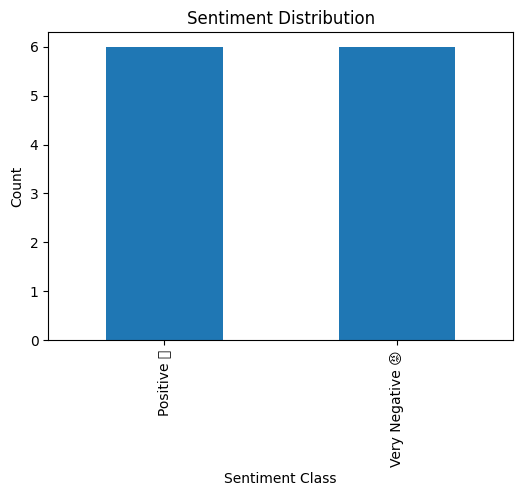

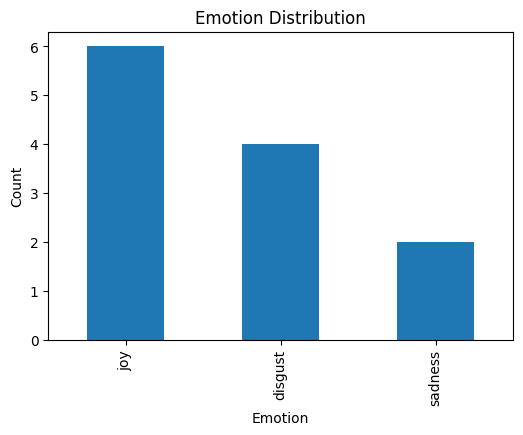



3️⃣ Sentiment–Emotion Summary Table




,Sentiment,Emotion,Count
0,Positive 🙂,joy,6
1,Very Negative 😡,disgust,4
2,Very Negative 😡,sadness,2




4️⃣ Summary table saved to: /content/sentiment_emotion_summary.csv


5️⃣ Outputs generated:
-  Structured results table
-  Sentiment distribution plot
-  Emotion distribution plot
-  Sentiment–Emotion summary table


In [65]:
# =======================================
# Phase 5.2 – Results Storage & Visualization
# (Single Cell – Summary Table Restored)
# =======================================

import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1️⃣ Run Inference (Phase 5.1)
# -------------------------------
results = predict_sentiment_with_emotion(sample_reviews)

# -------------------------------
# 2️⃣ Store Results in DataFrame
# -------------------------------
df_results = pd.DataFrame(results)
print("1️⃣ Structured Results Table")
print("\n")

display(df_results)

# -------------------------------
# 3️⃣ Save Full Results to CSV
# -------------------------------
results_csv_path = "/content/final_sentiment_emotion_results.csv"
df_results.to_csv(results_csv_path, index=False)

print("\n")
print(f"2️⃣ Full results saved to: {results_csv_path}")
print("\n")

# -------------------------------
# 4️⃣ Sentiment Distribution Plot
# -------------------------------
sentiment_counts = df_results["Sentiment"].value_counts()
plt.figure(figsize=(6,4))
sentiment_counts.plot(kind="bar")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.show()

# -------------------------------
# 5️⃣ Emotion Distribution Plot
# -------------------------------
emotion_counts = df_results["Emotion"].value_counts()

plt.figure(figsize=(6,4))
emotion_counts.plot(kind="bar")
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

# -------------------------------
# 6️⃣ Sentiment–Emotion Summary Table (RESTORED)
# -------------------------------
summary_table = (
    df_results
    .groupby(["Sentiment", "Emotion"])
    .size()
    .reset_index(name="Count")
)

print("\n")
print("3️⃣ Sentiment–Emotion Summary Table")
print("\n")
display(summary_table)

# -------------------------------
# 7️⃣ Save Summary Table to CSV
# -------------------------------
summary_csv_path = "/content/sentiment_emotion_summary.csv"
summary_table.to_csv(summary_csv_path, index=False)

print("\n")
print(f"4️⃣ Summary table saved to: {summary_csv_path}")
print("\n")

# -------------------------------
# 8️⃣ Final Confirmation
# -------------------------------
print("5️⃣ Outputs generated:")
print("-  Structured results table")
print("-  Sentiment distribution plot")
print("-  Emotion distribution plot")
print("-  Sentiment–Emotion summary table")


